# Capstone Project – The Battle of Neighborhoods (Part2)

## Installing Libraries

In [1]:
!pip install geocoder
!pip install folium

In [2]:
import requests
import numpy as np
import pandas as pd
import geocoder
import folium
import requests 
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
import xml
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from pandas.io.json import json_normalize 
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim 
from bs4 import BeautifulSoup

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print("All Required Libraries Imported!")

All Required Libraries Imported!


## Import Data

Data Link :https://www.kaggle.com/shaswatd673/delhi-neighborhood-data

In [3]:
delhi_data= pd.read_csv("I:\datasets_512081_944688_delhi_dataSet.csv")
delhi_data.head()

,Unnamed: 0,Borough,Neighborhood,latitude,longitude
0,0,North West Delhi,Adarsh Nagar,28.614192,77.071541
1,1,North West Delhi,Ashok Vihar,28.699453,77.184826
2,2,North West Delhi,Azadpur,28.707657,77.175547
3,3,North West Delhi,Bawana,28.799660,77.032885
4,4,North West Delhi,Begum Pur,NaN,NaN


In [4]:
delhi_data.drop('Unnamed: 0',axis=1,inplace=True)


In [5]:
delhi_data.head()

,Borough,Neighborhood,latitude,longitude
0,North West Delhi,Adarsh Nagar,28.614192,77.071541
1,North West Delhi,Ashok Vihar,28.699453,77.184826
2,North West Delhi,Azadpur,28.707657,77.175547
3,North West Delhi,Bawana,28.799660,77.032885
4,North West Delhi,Begum Pur,NaN,NaN


In [19]:
delhi_df=delhi_data.dropna()

In [20]:
delhi_df.describe()

,latitude,longitude
count,163.000000,163.000000
mean,29.253671,66.929529
std,2.508360,40.310497
min,28.433762,-90.261223
25%,28.564461,77.144763
50%,28.629489,77.206707
75%,28.671847,77.245291
max,39.031714,77.322064


In [21]:
delhi_df.shape

(163, 4)

In [22]:
delhi_df.head()

,Borough,Neighborhood,latitude,longitude
0,North West Delhi,Adarsh Nagar,28.614192,77.071541
1,North West Delhi,Ashok Vihar,28.699453,77.184826
2,North West Delhi,Azadpur,28.707657,77.175547
3,North West Delhi,Bawana,28.799660,77.032885
5,North West Delhi,Dhaka,39.031714,-90.261223


## Map of Delhi

In [23]:
geolocator=Nominatim(user_agent="https://www.courseracapstoneproject.com")
city='delhi'
country='India'
loc = geolocator.geocode(city+'.'+country)
latitude_x=loc.latitude
longitude_y=loc.longitude
print('lattitude_x:',loc.latitude,'longitude_y:',loc.longitude)


lattitude_x: 28.6517178 longitude_y: 77.2219388


In [25]:
map_Delhi = folium.Map(location=[latitude_x, longitude_y], zoom_start=10)

for lat, lng, nei in zip(delhi_df['latitude'], delhi_df['longitude'], delhi_df['Neighborhood']):
    
    label = '{}'.format(nei)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Delhi)  
    
map_Delhi

## FourSquare API

In [26]:
CLIENT_ID = '1CDTLGFGJRIK54AO3IC0VVQP1YFFJ1ULCPFPBPFSOSO4XGF2' # my Foursquare ID
CLIENT_SECRET = '5JYBFUWTYNURE4Z4JIRYYNZOBMZTAOPYYFTCOI5N4VFFRT2H' # my Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: '+CLIENT_ID)
print('CLIENT_SECRET: '+CLIENT_SECRET)

Your credentails:
CLIENT_ID: 1CDTLGFGJRIK54AO3IC0VVQP1YFFJ1ULCPFPBPFSOSO4XGF2
CLIENT_SECRET: 5JYBFUWTYNURE4Z4JIRYYNZOBMZTAOPYYFTCOI5N4VFFRT2H


In [28]:
radius = 700 
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude_x, 
   longitude_y, 
    radius, 
   LIMIT)
results = requests.get(url).json()

In [29]:
venues=results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.columns

Index(['referralId', 'reasons.count', 'reasons.items', 'venue.id',
       'venue.name', 'venue.location.address', 'venue.location.crossStreet',
       'venue.location.lat', 'venue.location.lng',
       'venue.location.labeledLatLngs', 'venue.location.distance',
       'venue.location.cc', 'venue.location.country',
       'venue.location.formattedAddress', 'venue.categories',
       'venue.photos.count', 'venue.photos.groups',
       'venue.location.postalCode', 'venue.location.neighborhood',
       'venue.location.city', 'venue.location.state'],
      dtype='object')

In [30]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

## Nearby Venues

In [31]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Amritsari Lassi Wala,"[{'id': '4bf58dd8d48988d1c7941735', 'name': 'S...",28.657325,77.224138
1,Spice Market,"[{'id': '4bf58dd8d48988d1f9941735', 'name': 'F...",28.657287,77.222595
2,Giani's Di Hatti Rabri Faluda,"[{'id': '4bf58dd8d48988d1d0941735', 'name': 'D...",28.657889,77.223296
3,Chawri Bazaar | चावड़ी बाजार,"[{'id': '4bf58dd8d48988d112951735', 'name': 'H...",28.649771,77.227364
4,Nai Sarak | नई सड़क,"[{'id': '4bf58dd8d48988d121951735', 'name': 'P...",28.652839,77.228708


In [32]:
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(5)

,name,categories,lat,lng
0,Amritsari Lassi Wala,Snack Place,28.657325,77.224138
1,Spice Market,Food & Drink Shop,28.657287,77.222595
2,Giani's Di Hatti Rabri Faluda,Dessert Shop,28.657889,77.223296
3,Chawri Bazaar | चावड़ी बाजार,Hardware Store,28.649771,77.227364
4,Nai Sarak | नई सड़क,Paper / Office Supplies Store,28.652839,77.228708


## Category of Venues

In [33]:
# Top 10 Categories
a=pd.Series(nearby_venues.categories)
a.value_counts()[:10]

Dessert Shop                     2
Hardware Store                   1
Hotel                            1
Snack Place                      1
Fast Food Restaurant             1
Food & Drink Shop                1
Paper / Office Supplies Store    1
Name: categories, dtype: int64

In [34]:
def getNearbyVenues(names, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # making GET request
        venue_results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [36]:
delhi_venues = getNearbyVenues(names=delhi_df['Neighborhood'],
                                   latitudes=delhi_df['latitude'],
                                   longitudes=delhi_df['longitude']
                                  )

Adarsh Nagar
Ashok Vihar
Azadpur
Bawana
Dhaka
Jahangirpuri
Karala
Keshav Puram
Kingsway Camp
Kohat Enclave
Model Town
Narela
Pitam Pura
Rani Bagh
Rithala
Shalimar Bagh
Shakti Nagar
Bara Hindu Rao
Chandni Chowk
Chawri Bazaar
Civil Lines
Dariba Kalan
Kamla Nagar
Kashmiri Gate
Kotwali
Lahori Gate
Nehru Vihar
Paharganj
Pratap Nagar
Pul Bangash
Roshanara Bagh
Sangam Vihar
Sant Nagar
Sarai Kale Khan
Sarai Rohilla
Shakti Nagar
Shastri Nagar
Timarpur
Wazirabad
Babarpur
Dilshad Garden
Kabir Nagar
Mandoli
Maujpur
Nand Nagri
Naveen Shahdara
Shahdara
Sonia Vihar
Shastri Park
Yamuna Vihar
Chandni Chowk
Daryaganj
Jhandewalan
Karol Bagh
Bara Hindu Rao
Paharganj
Barakhamba Road
Chanakyapuri
Connaught Place
Gautampuri
Gole Market
Golf Links
INA Colony
Khan Market
Pragati Maidan
Brij Puri
East Vinod Nagar
Gandhi Nagar
Geeta Colony
Jhilmil Colony
Krishna Nagar
Laxmi Nagar
Mayur Vihar
Pandav Nagar
Patparganj
Preet Vihar
Anand Vihar
Shakarpur
Shastri Nagar
Vasundhara Enclave
Vishwas Nagar
Vivek Vihar
Shahd

In [37]:

print('There are {} Uniques Categories.'.format(len(delhi_venues['Venue Category'].unique())))
delhi_venues.groupby('Neighborhood').count().head()

There are 193 Uniques Categories.


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Adarsh Nagar,1,1,1,1,1,1
Alaknanda,9,9,9,9,9,9
Anand Vihar,8,8,8,8,8,8
Ashok Nagar,2,2,2,2,2,2
Ashok Vihar,10,10,10,10,10,10


## OneHot Encoding of Features

In [40]:
# one hot encoding
delhi_onehot = pd.get_dummies(delhi_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
delhi_onehot['Neighborhood'] = delhi_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [delhi_onehot.columns[-1]] + list(delhi_onehot.columns[:-1])
delhi_onehot = delhi_onehot[fixed_columns]
delhi_grouped = delhi_onehot.groupby('Neighborhood').mean().reset_index()
delhi_onehot.head(5)

,Yoga Studio,ATM,Accessories Store,Airport,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Basketball Court,Bed & Breakfast,Beer Garden,Bengali Restaurant,Big Box Store,Bistro,Bookstore,Boutique,Breakfast Spot,Buffet,Burger Joint,Burmese Restaurant,Bus Station,Business Service,Cafeteria,Café,Campground,Castle,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store,Dessert Shop,Dhaba,Dim Sum Restaurant,Diner,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Event Space,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Flea Market,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gastropub,Gift Shop,Golf Course,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Historic Site,History Museum,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,IT Services,Ice Cream Shop,Indian Restaurant,Indian Sweet Shop,Indie Movie Theater,Irani Cafe,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Light Rail Station,Liquor Store,Lounge,Market,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Mosque,Movie Theater,Moving Target,Mughlai Restaurant,Multicuisine Indian Restaurant,Multiplex,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Nightlife Spot,North Indian Restaurant,Other Great Outdoors,Other Nightlife,Paper / Office Supplies Store,Park,Parsi Restaurant,Pedestrian Plaza,Performing Arts Venue,Pharmacy,Pizza Place,Platform,Playground,Plaza,Pool,Portuguese Restaurant,Pub,Public Art,Punjabi Restaurant,Racetrack,Restaurant,Road,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Smoke Shop,Snack Place,Soccer Stadium,Soup Place,South Indian Restaurant,Spa,Spanish Restaurant,Speakeasy,Spiritual Center,Sporting Goods Shop,Sports Bar,Stables,Stadium,Steakhouse,Supermarket,Tapas Restaurant,Tea Room,Tex-Mex Restaurant,Thai Restaurant,Theater,Tibetan Restaurant,Toy / Game Store,Track Stadium,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Warehouse Store,Whisky Bar,Wine Bar,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Adarsh Nagar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Ashok Vihar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Ashok Vihar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [41]:
num_top_venues = 5
for hood in delhi_grouped['Neighborhood']:
    print("---- "+hood+" ----")
    temp =delhi_grouped[delhi_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- Adarsh Nagar ----
                            venue  freq
0               Indian Restaurant   1.0
1                     Yoga Studio   0.0
2            Other Great Outdoors   0.0
3              Mughlai Restaurant   0.0
4  Multicuisine Indian Restaurant   0.0


---- Alaknanda ----
                     venue  freq
0                BBQ Joint  0.22
1  New American Restaurant  0.11
2        Food & Drink Shop  0.11
3               Restaurant  0.11
4                      Gym  0.11


---- Anand Vihar ----
               venue  freq
0  Indian Restaurant  0.25
1        Pizza Place  0.12
2         Soup Place  0.12
3  Indian Sweet Shop  0.12
4     Ice Cream Shop  0.12


---- Ashok Nagar ----
                            venue  freq
0                      Smoke Shop   0.5
1                Business Service   0.5
2                     Yoga Studio   0.0
3                   Moving Target   0.0
4  Multicuisine Indian Restaurant   0.0


---- Ashok Vihar ----
              venue  freq
0       Snack Pla

In [42]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [44]:
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = delhi_grouped['Neighborhood']

for ind in np.arange(delhi_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(delhi_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adarsh Nagar,Indian Restaurant,Women's Store,Event Space,Food Truck,Food Court,Food & Drink Shop,Food,Flea Market,Fast Food Restaurant,Farmers Market
1,Alaknanda,BBQ Joint,Thai Restaurant,Food & Drink Shop,Coffee Shop,Restaurant,New American Restaurant,Market,Gym,Event Space,Food
2,Anand Vihar,Indian Restaurant,Pizza Place,Punjabi Restaurant,Fast Food Restaurant,Soup Place,Indian Sweet Shop,Ice Cream Shop,Hotel,Eastern European Restaurant,Food
3,Ashok Nagar,Smoke Shop,Business Service,Women's Store,French Restaurant,Food Court,Food & Drink Shop,Food,Flea Market,Fast Food Restaurant,Farmers Market
4,Ashok Vihar,Snack Place,Track Stadium,Department Store,Bank,Bakery,Sandwich Place,Asian Restaurant,Coffee Shop,Indian Restaurant,Dog Run


## k-Means Clustering Approach

In [46]:
# Using K-Means to cluster neighborhood into 3 clusters
delhi_grouped_clustering = delhi_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=3, random_state=0).fit(delhi_grouped_clustering)
kmeans.labels_

array([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2])

In [49]:


delhi_merged =delhi_df.iloc[:16,:]


delhi_merged = delhi_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

delhi_merged.head()

,Borough,Neighborhood,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North West Delhi,Adarsh Nagar,28.614192,77.071541,1.0,Indian Restaurant,Women's Store,Event Space,Food Truck,Food Court,Food & Drink Shop,Food,Flea Market,Fast Food Restaurant,Farmers Market
1,North West Delhi,Ashok Vihar,28.699453,77.184826,1.0,Snack Place,Track Stadium,Department Store,Bank,Bakery,Sandwich Place,Asian Restaurant,Coffee Shop,Indian Restaurant,Dog Run
2,North West Delhi,Azadpur,28.707657,77.175547,1.0,ATM,Ice Cream Shop,Airport Service,Bus Station,Restaurant,Women's Store,Event Space,Food Court,Food & Drink Shop,Food
3,North West Delhi,Bawana,28.799660,77.032885,1.0,Playground,Mobile Phone Shop,Fabric Shop,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Food,Flea Market,Fast Food Restaurant
5,North West Delhi,Dhaka,39.031714,-90.261223,0.0,Smoke Shop,Business Service,Women's Store,French Restaurant,Food Court,Food & Drink Shop,Food,Flea Market,Fast Food Restaurant,Farmers Market


## Mapping Clusters

In [50]:
kclusters = 10

In [59]:

# create map
map_clusters = folium.Map(location=[latitude_x, longitude_y], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)
# add markers to the map

markers_colors = []
for lat, lon, nei , cluster in zip(delhi_merged['latitude'], 
                                   delhi_merged['longitude'], 
                                   delhi_merged['Neighborhood'], 
                                   delhi_merged['Cluster Labels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

['#8000ff', '#4856fb', '#10a2f0', '#2adddd', '#62fbc4', '#9cfba4', '#d4dd80', '#ffa256', '#ff562c', '#ff0000']


In [60]:
df1=delhi_merged.loc[delhi_merged['Cluster Labels'] == 0,delhi_merged.columns[[2] + list(range(5, delhi_merged.shape[1]))]]
df2=delhi_merged.loc[delhi_merged['Cluster Labels'] == 1,delhi_merged.columns[[2] + list(range(5, delhi_merged.shape[1]))]]
df3=delhi_merged.loc[delhi_merged['Cluster Labels'] == 2,delhi_merged.columns[[2] + list(range(5, delhi_merged.shape[1]))]]

## Average Housing Prices

In [72]:
delhi_Avg_HousingPrice=pd.DataFrame({"Neighborhood":delhi_df["Neighborhood"],
                                      "Average_Housing_Price":[335000.0,286600.0,175000.0,225900.0,219400.0,
                                                               573900.0,225000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,225000.0,370500.,255400.0,433500.0,433500.0,
                                                               435000.0,289500.0,265000.0,285900.0,239400.0,
                                                               589900.0,295000.0,380500.0,378500.0,438500.0,229200.0,
                                                               229200.0,365000.0,388500.,285400.0,493500.0,477500.0,378000.0,316600.0,195000.0,225900.0,219400.0,
                                                               573900.0,367000.0,370500.0,370500.0,363500.0,279200.0,
                                                               279200.0,271000.0,370500.,255400.0,383500.0,433500.0,335000.0,286600.0,185000.0,225900.0,219400.0,
                                                               573900.0,329000.0,370500.0,370500.0,533500.0,279200.0,
                                                               279200.0,375000.0,370500.,255400.0,493500.0,433500.0,335000.0,286600.0,165000.0,225900.0,219400.0,
                                                               573900.0,425000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,195000.0,370500.,255400.0,403500.0,433500.0,335000.0,286600.0,187000.0,225900.0,219400.0,
                                                               573900.0,325000.0,370500.0,370500.0,333500.0,279200.0,
                                                               279200.0,289000.0,370500.,255400.0,413500.0,433500.0,254800.0,
                    435000.0,289500.0,265000.0,285900.0,239400.,589900.0,295000.0,380500.0,378500.0,438500.0,229200.0,
                                                               229200.0,365000.0,388500.,285400.0,493500.0,477500.0,378000.0,316600.0,195000.0,225900.0,219400.0,
                                                               573900.0,367000.0,370500.0,370500.0,363500.0,279200.0,
                                                               279200.0,271000.0,573900.0,329000.0,   279200.0,375000.0,370500.,255400.0,493500.0,433500.0,335000.0,
                                                               435000.0,289500.0,265000.0,285900.0,239400.0,
                                                               589900.0,295000.0,380500.0,378500.0,438500.0,229200.0,279200.0,225000.0,370500.,255400.0,433500.0,433500.0,
                                                               435000.0,289500.0,265000.0,285900.0
                                                              ]})

In [73]:
delhi_Avg_HousingPrice.set_index('Neighborhood',inplace=True,drop=True)

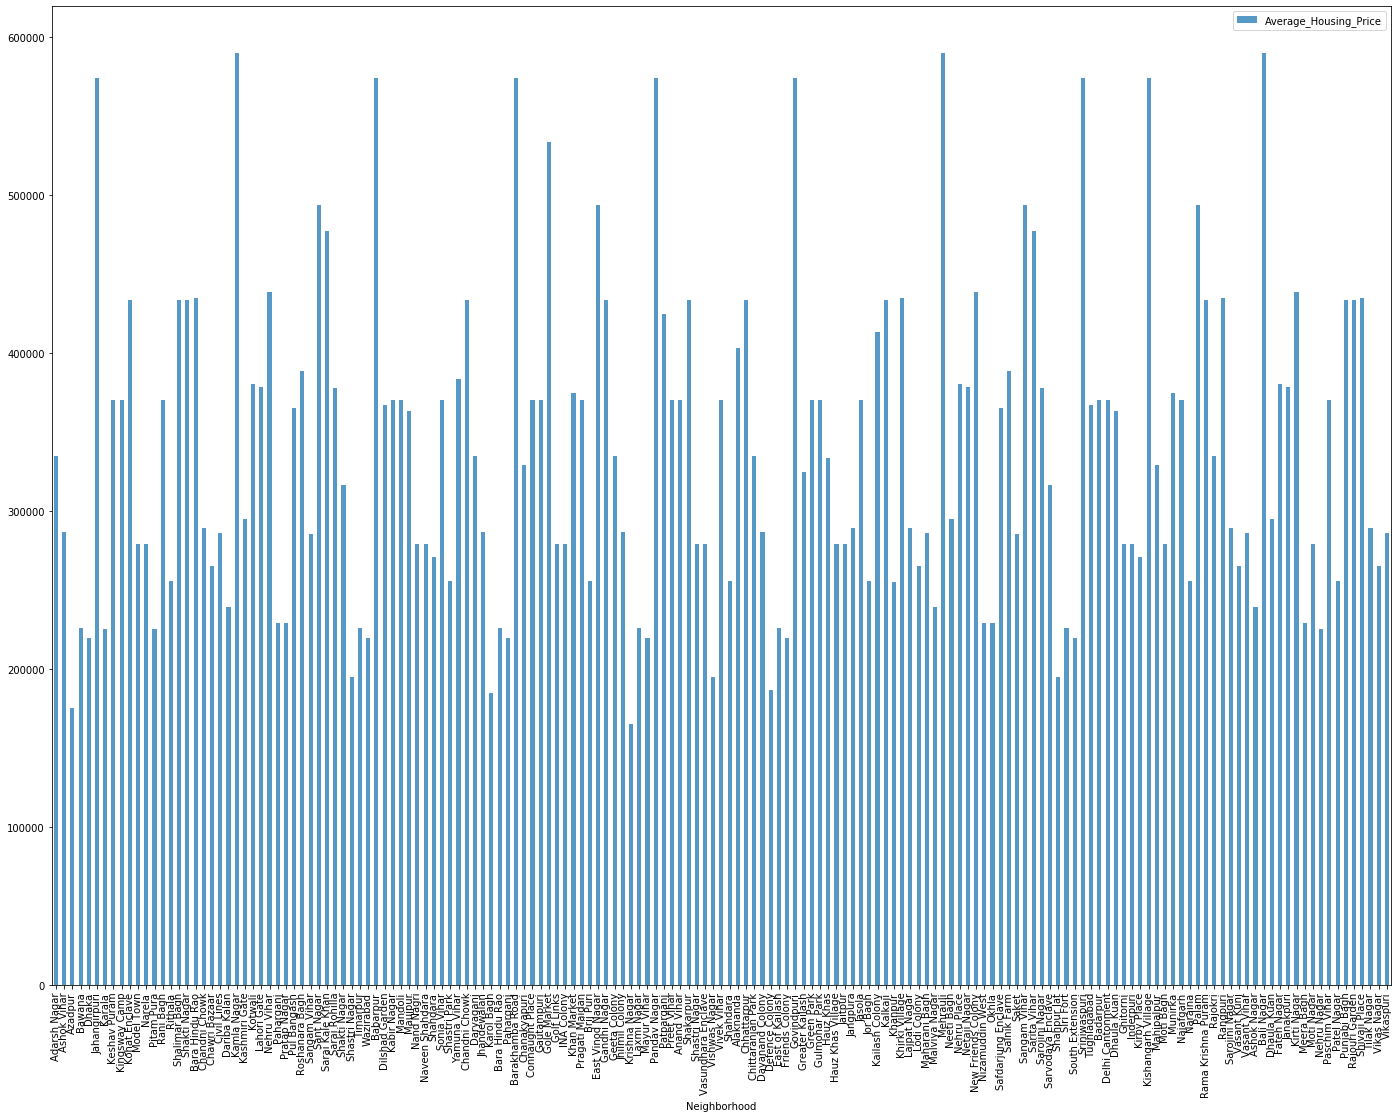

In [74]:
delhi_Avg_HousingPrice.plot(kind='bar',figsize=(24,18),alpha=0.75)